In [56]:
import pandas as pd
import sktime as skt
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_absolute_scaled_error

from prophet import Prophet
from sklearn.model_selection import train_test_split

from utilities import *

# Variables

In [57]:
predicted_col = "day_close"
start_halving = 2
train_size = 0.85

# Preprocessing

In [58]:
df = load_data()
df.head(10)

,Time,active-addresses-btc-24h,block-height-btc-24h,block-interval-mean-btc-24h,block-interval-median-btc-24h,block-size-mean-btc-24h,block-size-total-btc-24h,blocks-mined-btc-24h,circulating-supply-btc-24h,difficulty-btc-24h,...,transfer-volume-median-btc-24h,transfer-volume-total-btc-24h,utx-os-created-btc-24h,utx-os-spent-btc-24h,utxo-value-created-mean-btc-24h,utxo-value-created-median-btc-24h,utxo-value-created-total-btc-24h,utxo-value-spent-mean-btc-24h,utxo-value-spent-median-btc-24h,utxo-value-spent-total-btc-24h
0,2010-08-17 00:00:00+00:00,365.0,74916.0,659.201550,410.0,675.527132,87143.0,129.0,3745850.0,2.198051e+12,...,50.0,49995.99,419.0,292.0,134.715967,50.0,56445.99,171.219144,50.00,49995.99
1,2010-08-18 00:00:00+00:00,595.0,75049.0,661.496241,455.0,2005.503759,266732.0,133.0,3752500.0,2.198051e+12,...,50.0,37386.94,527.0,1302.0,83.564516,49.0,44038.50,28.716206,0.01,37388.50
2,2010-08-19 00:00:00+00:00,336.0,75184.0,635.518519,429.0,623.651852,84193.0,135.0,3759250.0,2.198051e+12,...,50.0,20402.10,415.0,271.0,65.426747,50.0,27152.10,75.284502,50.00,20402.10
3,2010-08-20 00:00:00+00:00,480.0,75377.0,447.398964,288.0,595.834197,114996.0,193.0,3768900.0,2.198051e+12,...,50.0,29578.41,538.0,388.0,72.915260,50.0,39228.41,76.233015,50.00,29578.41
4,2010-08-21 00:00:00+00:00,365.0,75550.0,501.942197,356.0,539.421965,93320.0,173.0,3777550.0,2.198051e+12,...,50.0,38678.31,437.0,286.0,108.302769,50.0,47328.31,135.238846,50.00,38678.31
5,2010-08-22 00:00:00+00:00,387.0,75762.0,408.674528,287.0,472.556604,100182.0,212.0,3788150.0,2.198051e+12,...,50.0,20418.19,432.0,322.0,71.801366,50.0,31018.19,63.410528,50.00,20418.19
6,2010-08-23 00:00:00+00:00,453.0,75975.0,404.239437,265.0,488.107981,103967.0,213.0,3798800.0,2.198051e+12,...,50.0,17776.11,445.0,338.0,63.878899,50.0,28426.11,52.592041,50.00,17776.11
7,2010-08-24 00:00:00+00:00,448.0,76190.0,402.967442,298.0,836.125581,179767.0,215.0,3809550.0,2.198051e+12,...,50.0,21093.11,465.0,753.0,68.481527,50.0,31843.91,28.013161,0.01,21093.91
8,2010-08-25 00:00:00+00:00,311.0,76406.0,398.833333,254.0,415.458333,89739.0,216.0,3820350.0,2.198051e+12,...,50.0,15911.10,428.0,230.0,62.409112,50.0,26711.10,69.178696,50.00,15911.10
9,2010-08-26 00:00:00+00:00,455.0,76616.0,446.733333,274.0,562.547619,118135.0,210.0,3830850.0,2.677427e+12,...,4.9,14247.79,435.0,404.0,56.891471,50.0,24747.79,35.266807,5.00,14247.79


In [59]:
df = preprocess_df(df, start_halving=start_halving)

In [60]:
df.columns

Index(['Time', 'active-addresses-btc-24h', 'block-height-btc-24h',
       'block-interval-mean-btc-24h', 'block-interval-median-btc-24h',
       'block-size-mean-btc-24h', 'block-size-total-btc-24h',
       'blocks-mined-btc-24h', 'circulating-supply-btc-24h',
       'difficulty-btc-24h', 'ma128', 'ma14', 'ma200', 'ma25', 'ma40', 'ma60',
       'ma9', 'ma90', 'fees-mean-btc-24h', 'fees-median-btc-24h',
       'fees-total-btc-24h', 'hash-rate-btc-24h',
       'investor-capitalization-btc-24h', 'market-cap-btc-24h',
       'new-addresses-btc-24h', 'price-drawdown-from-ath-btc-24h', 'day_close',
       'day_high', 'day_low', 'day_open',
       'realized-profits-to-value-rpv-ratio-btc-24h',
       'receiving-addresses-btc-24h', 'seller-exhaustion-constant-btc-24h',
       'sending-addresses-btc-24h', 'sopr-btc-24h', 'o.daysTillHalving',
       'o.ratio', 'supply-last-active-1-years-ago-btc-24h',
       'total-addresses-btc-24h', 'transaction-count-btc-24h',
       'transaction-rate-btc-24h

# Analysis

In [61]:
# This can provide lots of functions related to rolling averages etc.
ewm = df.ewm(span=7)
ewm.mean()["day_close"]

2155      651.152424
2156      659.219606
2157      657.485972
2158      658.511856
2159      661.107515
            ...     
4092    61269.470252
4093    61293.852660
4094    61234.946061
4095    61720.352492
4096    62040.044970
Name: day_close, Length: 1942, dtype: float64

# Prediction

## Thetaforecaster

In [62]:
y_train, y_test = temporal_train_test_split(df[predicted_col], train_size=train_size)
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = ThetaForecaster()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
mean_absolute_scaled_error(y_test, y_pred, y_train=y_train)

C:\Softwarez\Anaconda\envs\BitDictor\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


10885.456773183732

## Prophet

In [73]:
pf_df = preprocess_for_prophet(df)
pf_y_train, pf_y_test = train_test_split(pf_df, train_size=train_size, shuffle=False)
pf = Prophet()
pf.add_regressor('investor-capitalization-btc-24h')
print(pf_y_train.shape, pf_y_test.shape)

(1650, 2) (292, 2)


In [74]:
pf.fit(pf_y_train)

ValueError: Regressor 'nfl_sunday' missing from dataframe

In [65]:
forecast = pf.predict(pf_y_test)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2021-01-16,24897.247030,22805.676565,27104.935691
1,2021-01-17,24727.693294,22451.406572,26840.180128
2,2021-01-18,24587.676984,22400.599582,26905.721125
3,2021-01-19,24421.736713,22261.096138,26554.906080
4,2021-01-20,24305.005963,22085.382435,26551.715210
...,...,...,...,...
287,2021-10-30,33994.620392,21396.036628,45215.274203
288,2021-10-31,34052.771892,21937.845408,44830.375088
289,2021-11-01,34144.723457,22255.049972,45318.853826
290,2021-11-02,34212.642446,22182.406051,45610.249393


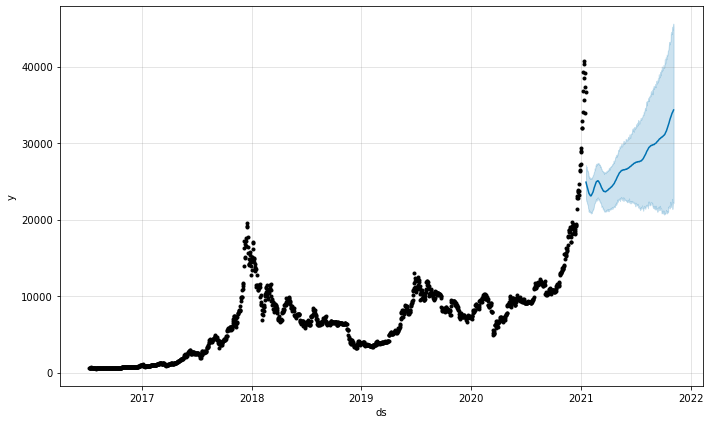

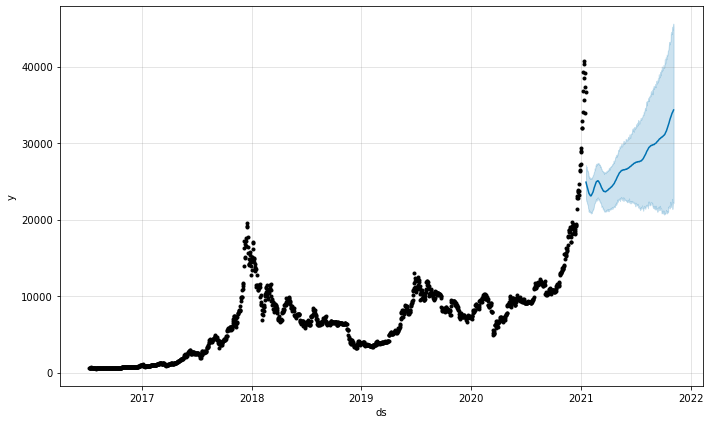

In [66]:
pf.plot(forecast)

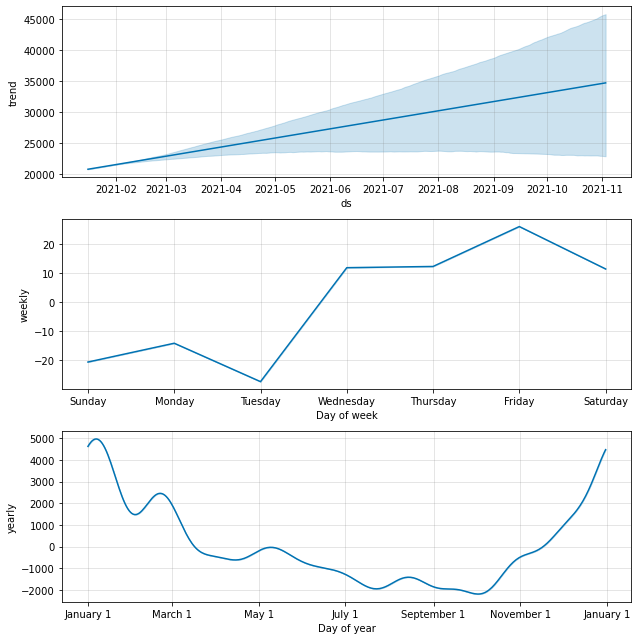

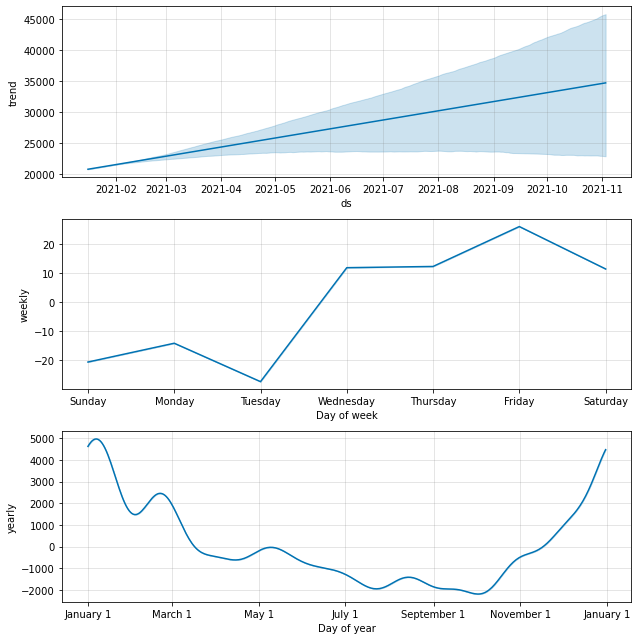

In [67]:
pf.plot_components(forecast)

In [71]:
mean_absolute_scaled_error(pf_y_test["y"], forecast["yhat"], y_train=pf_y_train["y"])

93.99427856767167